# Seasonal Auto Regressive Intregrated Moving Average(SARIMA) 

In [33]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import datetime,timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

# Catfish Sales data

In [13]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [8]:
df = pd.read_csv("catfish.csv")
df.head(6)

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239
5,1986-6-01,8951


In [12]:
df.describe()

,Total
count,324.000000
mean,19643.984568
std,5039.324331
min,8196.000000
25%,15764.000000
50%,19660.500000
75%,23604.500000
max,30485.000000


In [15]:
catfish_df = pd.read_csv("catfish.csv",parse_dates = [0], index_col= 0,squeeze = True, date_parser = parser)
catfish_df

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Name: Total, Length: 324, dtype: int64

In [17]:
#infer the frequency of the data
catfish_df = catfish_df.asfreq(pd.infer_freq(catfish_df.index))
catfish_df

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 324, dtype: int64

In [19]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
catfish_sales = catfish_df[start_date:end_date]

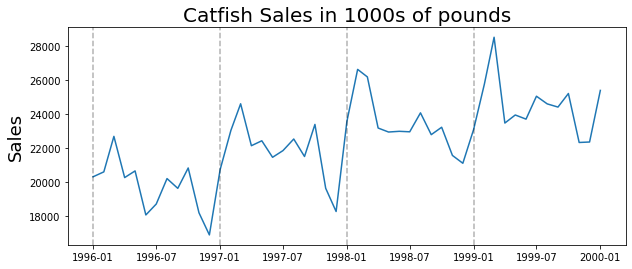

In [22]:
plt.figure(figsize = (10,4))
plt.plot(catfish_sales)
plt.title("Catfish Sales in 1000s of pounds", fontsize = 20)
plt.ylabel("Sales", fontsize = 18)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+ "-01-01"),color = "k",linestyle="--", alpha = 0.3)

# Remove the trend

In [23]:
first_diff = catfish_sales.diff()[1:]

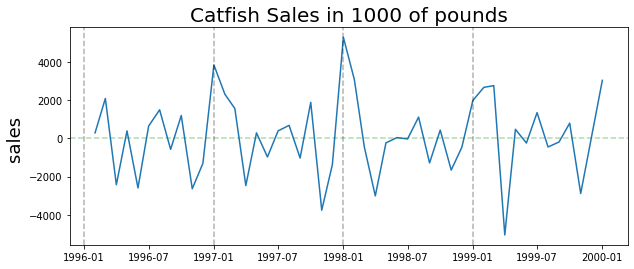

In [25]:
#plotting the first difference

plt.figure(figsize = (10,4))
plt.plot(first_diff)
plt.title("Catfish Sales in 1000 of pounds", fontsize = 20)
plt.ylabel("sales ", fontsize = 18)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+"-01-01"), color = "k", linestyle = "--",alpha = 0.3)
    
plt.axhline(0,color = "g",linestyle = "--",alpha = 0.3)

# ACF

<BarContainer object of 20 artists>

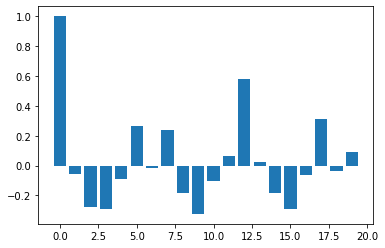

In [27]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

**Based on ACF ,we should start with seasonal MA process**

# PACF

/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


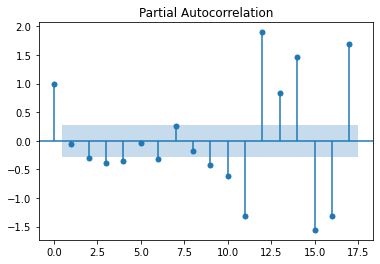

In [34]:
#pacf_vals = pacf(first_diff)
plot_pacf(first_diff)
plt.show()

**BAsed on PACF we should start with a seasonal AR process**

# Spliting the data

In [35]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = catfish_sales[:train_end]
test_data = catfish_sales[train_end + timedelta(days = 1):test_end]

# Fit the SARIMA model

In [36]:
my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)

#Define model
model = SARIMAX(train_data,order = my_order, seasonal_order = my_seasonal_order)

In [38]:
# Fit the model

start = time()
model_fit = model.fit()
end = time()
print("Model fitting time", end - start)

Model fitting time 0.38666677474975586


In [39]:
# Summary the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Mon, 29 Nov 2021   AIC                            737.269
Time:                                      01:45:56   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.848      0.000       0.589       1.061
ma.S.L12      -0.51

In [40]:
# Get prediction and residuals

predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index = test_data.index)
residuals = test_data - predictions

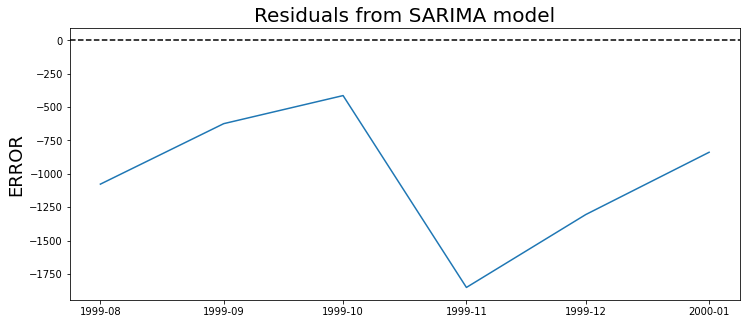

In [41]:
plt.figure(figsize = (12, 5))
plt.plot(residuals)
plt.title("Residuals from SARIMA model", fontsize = 20)
plt.ylabel("ERROR", fontsize = 18)
plt.axhline(0, color = "k", linestyle = "--")

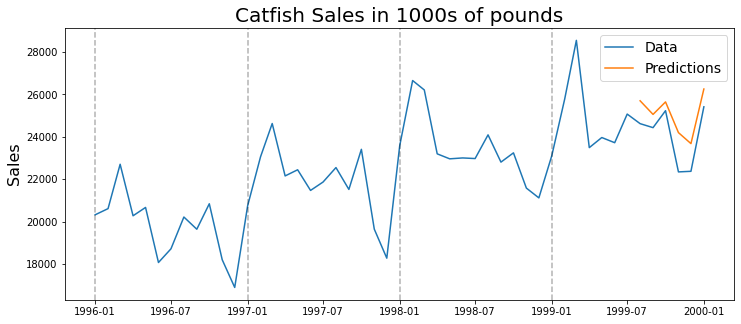

In [43]:
plt.figure(figsize = (12,5))

plt.plot(catfish_sales)
plt.plot(predictions)

plt.legend(("Data", "Predictions"), fontsize = 14)
plt.title("Catfish Sales in 1000s of pounds", fontsize = 20)
plt.ylabel("Sales", fontsize = 16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(str(year)+"-01-01"), color = "k", linestyle = "--", alpha = 0.3)

In [46]:
print("Mean Absolute Square Error :", round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Square Error : 0.0433


In [48]:
print("RMSE :", np.sqrt(np.mean(residuals**2)))

RMSE : 1122.3063633211395


# Using the Rolling Forecast Origin

In [50]:
rolling_prediction = test_data.copy()

for train_end in test_data.index:
    train_data = catfish_sales[:train_end - timedelta(days = 1)]
    model = SARIMAX(train_data, order = my_order, seasonal_order = my_seasonal_order )
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_prediction[train_end] = pred

/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90076D+00    |proj g|=  1.36395D+00

At iterate    5    f=  8.55735D+00    |proj g|=  2.79888D-01

At iterate   10    f=  8.53710D+00    |proj g|=  1.35918D-03

At iterate   15    f=  8.53709D+00    |proj g|=  1.20396D-03

At iterate   20    f=  8.53700D+00    |proj g|=  1.52533D-02

At iterate   25    f=  8.52075D+00    |proj g|=  5.96633D-03

At iterate   30    f=  8.51281D+00    |proj g|=  5.45067D-02

At iterate   35    f=  8.50313D+00    |proj g|=  1.59548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [51]:
rolling_residuals = test_data - rolling_prediction

Text(0, 0.5, 'Error')

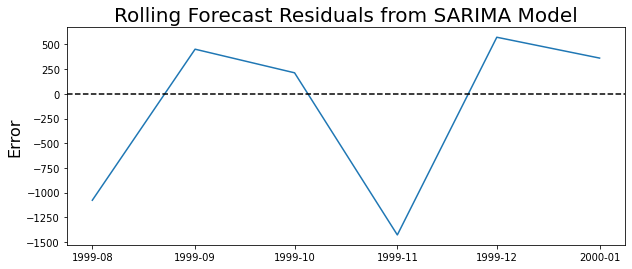

In [52]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

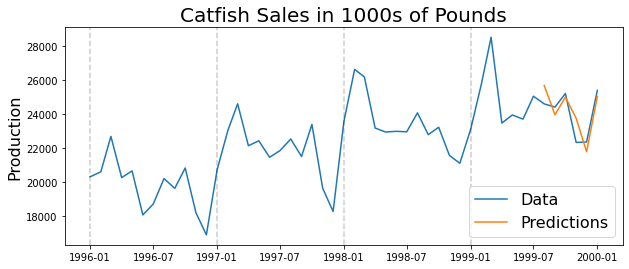

In [55]:
plt.figure(figsize=(10,4))

plt.plot(catfish_sales)
plt.plot(rolling_prediction)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [57]:
print("MAPE :", round(np.mean(abs(rolling_residuals/test_data)),4))

MAPE : 0.0291


In [58]:
print("RMSE :", np.sqrt(np.mean(rolling_residuals**2)))

RMSE : 807.0686670496714
